In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.tree import export_text
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

2025-08-18 22:07:53.637644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 22:07:53.638447: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 22:07:53.641333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 22:07:53.648786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755565673.660798   75071 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755565673.66

In [4]:
logon_data = pd.read_csv('data/logon.csv')
device_data = pd.read_csv('data/device.csv')
http_data = pd.read_csv('data/http_2.csv')

In [5]:
len(logon_data)
#logon_data.head()

867070

In [6]:
len(device_data)
#device_data.head()

825496

In [8]:
http_data.head()

,id,date,user,pc,url,content
0,{U0G4-P5TW04EO-9366IUQF},01/02/2010 06:36:20,EBH0519,PC-9573,http://usbank.com/1930_FIFA_World_Cup/patenaud...,neros printing pastiche four topiary body pink...
1,{G0R5-U4RX40DR-3710WPUY},01/02/2010 06:39:22,EBH0519,PC-9573,http://forbes.com/Chorioactis/urnula.html,balhae fubing guotu namsaeng geng chuzhou ying...
2,{G0Q6-F5CV96RX-0355APNP},01/02/2010 06:39:53,EBH0519,PC-9573,http://coupons.com/BeauchampSharp_Tragedy/darb...,ziyi hazelnuts 34850 stat_area1 namsaeng kucha...
3,{J8X0-C9ZO08VS-9370QIFO},01/02/2010 06:40:56,EBH0519,PC-9573,http://youtube.com/Amanita_ocreata/velosa.html,flambard anselm anselm precentor thurgot visit...
4,{E0J4-D6WM72LS-9186JPKE},01/02/2010 06:47:23,EBH0519,PC-9573,http://twitter.com/Cannon/m198.html,maternus henrici anselm walkelin maternus thur...


In [9]:
logon_data['user'].value_counts().head(10)

user
JVS0212    4966
ZNS0213    4852
HKW0211    4676
DWG0209    4620
BLA0039    4564
LUP0038    4560
UAP0214    4474
PAW0040    4302
WSP0210    1995
ABG0865    1680
Name: count, dtype: int64

In [10]:
logon_data.shape

(867070, 5)

In [11]:
logon_data['date'] = pd.to_datetime(logon_data['date'])
logon_data['day'] = logon_data['date'].dt.dayofweek
logon_data['hour'] = logon_data['date'].dt.hour

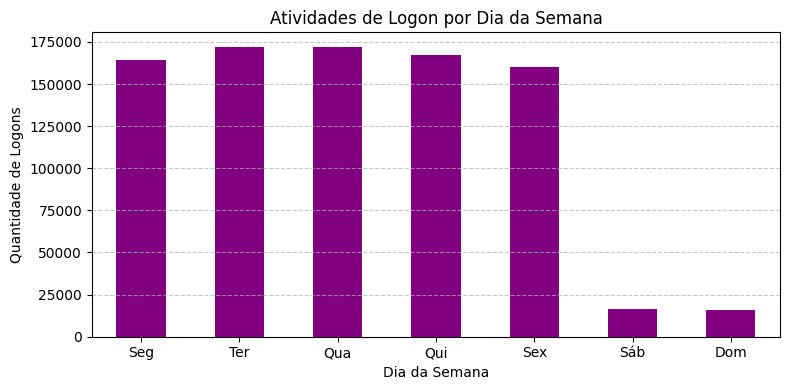

In [47]:
#GRAFICO ATIVIDADES LOGON DIAS DAS SEMANA

# Mapeamento dos dias da semana
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']

# Contagem ordenada por índice do dia
contagem_dias = logon_data['day'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 4))
contagem_dias.plot(kind='bar', color='purple')
plt.title('Atividades de Logon por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Logons')
plt.xticks(ticks=range(7), labels=dias_semana, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("imagens/grafico-atividade-de-logon-semana.png", dpi=300)
plt.show()


In [13]:
# Agregações principais por usuário

logon_features = logon_data.groupby('user').agg(
    computadores_distintos=('pc', 'nunique'),

    total_logons=('activity', lambda x: (x == 'Logon').sum()),
    total_logoffs=('activity', lambda x: (x == 'Logoff').sum()),

    computador_mais_usado=('pc', lambda x: x.value_counts().idxmax()),

    hora_logon_mais_comum=('hour', lambda x: x[logon_data.loc[x.index, 'activity'] == 'Logon'].mode()[0]
                           if not x[logon_data.loc[x.index, 'activity'] == 'Logon'].empty else -1),

    hora_logoff_mais_comum=('hour', lambda x: x[logon_data.loc[x.index, 'activity'] == 'Logoff'].mode()[0]
                            if not x[logon_data.loc[x.index, 'activity'] == 'Logoff'].empty else -1),

    # Logons no fim de semana (sábado=5 ou domingo=6)
    logons_fim_de_semana=('day', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                            (x.isin([5, 6]))).sum()),

    # Logons em dias úteis (segunda=0 a sexta=4)
    logons_dias_uteis=('day', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                         (x.isin([0, 1, 2, 3, 4]))).sum()),

    # Logons fora do horário comercial (antes de 7h ou após 18h) apenas em dias úteis
    logons_fora_horario_comercial=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                  (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                  ((x < 7) | (x > 18))).sum()),

    # Logons dentro do horário comercial (7h às 18h) apenas em dias úteis
    logons_em_horario_comercial=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                    (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                    ((x >= 7) & (x <= 18))).sum()),

    # Logons fora do horário comercial com janela de acesso (antes de 22h e após 18h) apenas em dias úteis
    logons_janela_acesso=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                  (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                  ((x < 22) & (x > 18))).sum()),

    proporcao_pc_mais_usado=('pc', lambda x: (x.value_counts().max() / len(x)))
).reset_index()

In [14]:
logon_features

,user,computadores_distintos,total_logons,total_logoffs,computador_mais_usado,hora_logon_mais_comum,hora_logoff_mais_comum,logons_fim_de_semana,logons_dias_uteis,logons_fora_horario_comercial,logons_em_horario_comercial,logons_janela_acesso,proporcao_pc_mais_usado
0,AAB0754,1,17,9,PC-5948,9,19,0,17,0,17,0,1.000000
1,AAC0070,1,345,345,PC-9582,7,18,0,345,0,345,0,1.000000
2,AAN0077,1,10,10,PC-9130,8,16,0,10,0,10,0,1.000000
3,AAP0946,2,727,458,PC-6599,8,18,0,727,0,727,0,0.809283
4,AAR0716,2,631,362,PC-8861,7,15,0,631,171,460,0,0.965760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZNF0145,2,22,15,PC-1673,8,17,3,19,0,19,0,0.837838
1996,ZNS0213,792,2562,2290,PC-3066,7,15,0,2562,1438,1124,409,0.198269
1997,ZSP0972,1,345,345,PC-5819,9,17,0,345,0,345,0,1.000000
1998,ZWF0919,1,17,10,PC-0742,7,17,0,17,0,17,0,1.000000


In [15]:
device_data['date'] = pd.to_datetime(device_data['date'])
device_data['day'] = device_data['date'].dt.dayofweek
device_data['hour'] = device_data['date'].dt.hour

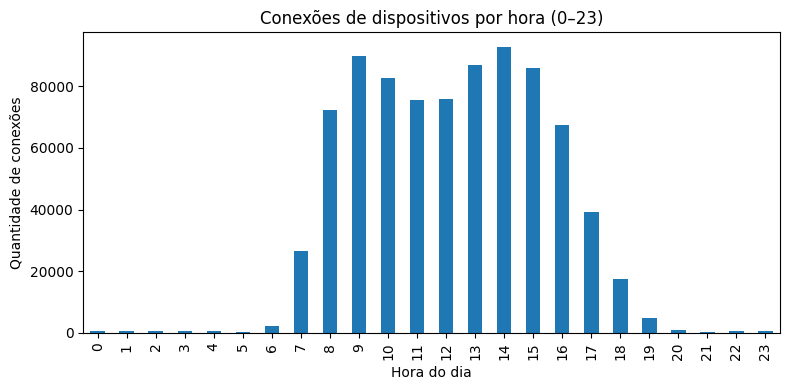

In [59]:
#CONEXOES DE USER

device_features = device_data.groupby('user').agg(

    pcs_distintos_dispositivo=('pc', 'nunique'),
    total_atividades_dispositivo=('activity', 'count'),

    # Conexões fora do horário comercial (dias úteis antes das 07h ou após as 18h)
    connect_fora_horario_comercial=('activity', lambda a: (
        ((a.str.contains('connect', case=False, na=False)) &
         (device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])) &
         ((device_data.loc[a.index, 'hour'] < 7) | (device_data.loc[a.index, 'hour'] > 18)))
    ).sum()),

    # Conexões dentro do horário comercial (dias úteis das 07h às 18h)
    connect_em_horario_comercial=('activity', lambda a: (
        ((a.str.contains('connect', case=False, na=False)) &
         (device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])) &
         ((device_data.loc[a.index, 'hour'] >= 7) & (device_data.loc[a.index, 'hour'] <= 18)))
    ).sum()),

    # Conexões fim de semana
    connect_fim_de_semana=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([5, 6])
    ).sum()),

    # Conexões dias úteis
    connect_dias_uteis=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])
    ).sum()),

    # Conexões na "janela de acesso" (dias úteis, entre 18h e 22h)
    connect_janela_acesso=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        (device_data.loc[a.index, 'hour'] > 18) &
        (device_data.loc[a.index, 'hour'] < 22)
    ).sum()),

    # Total de conexões
    total_connect_dispositivo=('activity', lambda a: a.str.contains('connect', case=False, na=False).sum()),

    # Total de desconexões
    total_disconnect_dispositivo=('activity', lambda a: a.str.contains('disconnect', case=False, na=False).sum()),

    # Diferença entre conexões e desconexões
    conexoes_sem_desconexao=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False).sum() -
        a.str.contains('disconnect', case=False, na=False).sum()
    ))
    

).reset_index()

# Série de conexões por hora (todas as conexões 'connect')
is_connect = device_data['activity'].str.contains('connect', case=False, na=False)
counts_by_hour = (device_data.loc[is_connect]
                  .groupby(device_data.loc[is_connect, 'hour'])
                  .size().reindex(range(24), fill_value=0))

plt.figure(figsize=(8,4))
counts_by_hour.plot(kind='bar')
plt.title('Conexões de dispositivos por hora (0–23)')
plt.xlabel('Hora do dia')
plt.ylabel('Quantidade de conexões')
plt.tight_layout()
plt.savefig("imagens/grafico-conexoes-de-dispositivo.png", dpi=300)
plt.show()




In [17]:
device_features

,user,pcs_distintos_dispositivo,total_atividades_dispositivo,connect_fora_horario_comercial,connect_em_horario_comercial,connect_fim_de_semana,connect_dias_uteis,connect_janela_acesso,total_connect_dispositivo,total_disconnect_dispositivo,conexoes_sem_desconexao
0,AAS0850,1,686,0,686,0,686,0,686,329,357
1,ABH0821,1,310,4,244,62,248,0,310,148,162
2,ABM0513,1,2095,0,2095,0,2095,0,2095,1034,1061
3,ABW0673,1,1964,0,1386,578,1386,0,1964,959,1005
4,ACR0100,1,219,0,219,0,219,0,219,102,117
...,...,...,...,...,...,...,...,...,...,...,...
432,ZED0676,1,675,0,675,0,675,0,675,326,349
433,ZNF0145,1,1618,0,1381,237,1381,0,1618,791,827
434,ZNS0213,1,670,0,670,0,670,0,670,323,347
435,ZWF0919,1,1280,0,1280,0,1280,0,1280,623,657


In [18]:
http_data['date'] = pd.to_datetime(http_data['date'])
http_data['day'] = http_data['date'].dt.dayofweek
http_data['hour'] = http_data['date'].dt.hour

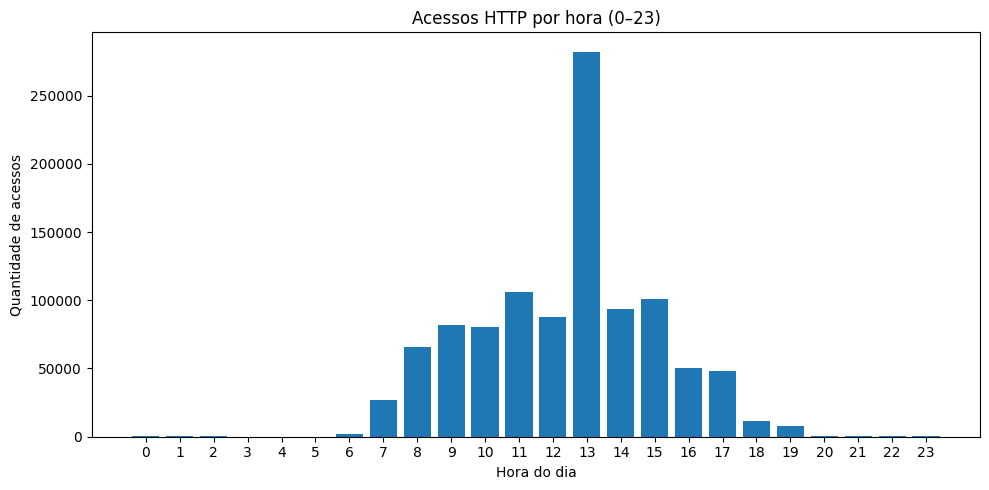

KeyError: 'logons_fora_horario_comercial'

<Figure size 800x500 with 0 Axes>

In [ ]:
#CONTROLE DE ACESSO

http_features = http_data.groupby('user').agg(

    # Quantidade de sites únicos visitados
    sites_distintos_visitados=('url', 'nunique'),

    # Total de acessos HTTP (linhas registradas)
    total_acessos_http=('url', 'count'),

    # Acessos fora do horário comercial (dias úteis antes das 07h ou após as 18h)
    acessos_fora_horario_comercial=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        ((http_data.loc[a.index, 'hour'] < 7) | (http_data.loc[a.index, 'hour'] > 18))
    ).sum()),

    # Acessos dentro do horário comercial (dias úteis das 07h às 18h)
    acessos_em_horario_comercial=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        ((http_data.loc[a.index, 'hour'] >= 7) & (http_data.loc[a.index, 'hour'] <= 18))
    ).sum()),

    # Acessos no fim de semana
    acessos_fim_de_semana=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([5, 6])
    ).sum()),

    # Acessos na janela de acesso (dias úteis, entre 18h e 22h)
    acessos_janela_acesso=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        (http_data.loc[a.index, 'hour'] > 18) & (http_data.loc[a.index, 'hour'] < 22)
    ).sum()),

    # Visitas a sites de compras
    visita_sites_compras=('url', lambda x: x.str.contains('alibaba|amazon|ebay', case=False, na=False).sum()),

    # Visitas a sites de notícias
    visita_sites_noticias=('url', lambda x: x.str.contains('examiner|discovery|foodnetwork|thechive|wsj', case=False, na=False).sum()),

    # Visitas a sites de entretenimento
    visita_sites_entretenimento=('url', lambda x: x.str.contains('soundcloud|m-w|youtube|cafemom|netflix', case=False, na=False).sum()),

    # Tamanho médio das URLs acessadas
    tamanho_medio_urls=('url', lambda x: x.dropna().astype(str).str.len().mean()),

    # Detecção de termos sensíveis relacionados à segurança no conteúdo acessado
    termos_sensiveis_detectados=('content', lambda x: x.dropna().astype(str).str.count(r'\bsecure\b|\bpassword\b').sum()),

    # Tamanho médio do conteúdo acessado (resposta HTTP)
    tamanho_medio_conteudo=('content', lambda x: x.dropna().astype(str).str.len().mean()),

    # Diferença entre número de acessos fora e dentro do horário comercial
    diferenca_acessos_fora_dentro=('url', lambda a: (
        (
            http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
            ((http_data.loc[a.index, 'hour'] < 7) | (http_data.loc[a.index, 'hour'] > 18))
        ).sum() -
        (
            http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
            ((http_data.loc[a.index, 'hour'] >= 7) & (http_data.loc[a.index, 'hour'] <= 18))
        ).sum()
    ))

).reset_index()


#plt.figure(figsize=(10,6))
#plt.hist(http_features['sites_distintos_visitados'], bins=30, edgecolor='black')
#plt.xlabel("Quantidade de Sites Distintos")
#plt.ylabel("Número de Usuários")
#plt.title("Distribuição de Sites Distintos Visitados por Usuários")
#plt.savefig("imagens/sites-distintos-por-user", dpi=300)
#plt.show()

# --- Acessos HTTP por hora (0..23) ---

# Garante que exista a coluna 'hour'
if 'hour' not in http_data.columns:
    http_data['date'] = pd.to_datetime(http_data['date'], errors='coerce')
    http_data = http_data.dropna(subset=['date'])
    http_data['hour'] = http_data['date'].dt.hour

# Conta acessos por hora (todas as linhas = todos os acessos)
acessos_por_hora = (
    http_data
    .groupby('hour')
    .size()                             # conta linhas (acessos)
    .reindex(range(24), fill_value=0)   # garante 0..23
)

# Plot
plt.figure(figsize=(10,5))
plt.bar(acessos_por_hora.index, acessos_por_hora.values)
plt.title('Acessos HTTP por hora (0–23)')
plt.xlabel('Hora do dia')
plt.ylabel('Quantidade de acessos')
plt.xticks(range(0,24))
plt.tight_layout()
plt.savefig("imagens/grafico-acessos-http-hora.png", dpi=300)
plt.show()





In [20]:
http_features

,user,sites_distintos_visitados,total_acessos_http,acessos_fora_horario_comercial,acessos_em_horario_comercial,acessos_fim_de_semana,acessos_janela_acesso,visita_sites_compras,visita_sites_noticias,visita_sites_entretenimento,tamanho_medio_urls,termos_sensiveis_detectados,tamanho_medio_conteudo,diferenca_acessos_fora_dentro
0,AAC0070,162,230,0,230,0,0,3,3,22,51.747826,0,414.404348,-230
1,AAP0946,415,1207,0,1207,0,0,18,11,152,51.148302,0,408.922121,-1207
2,AAR0716,100,115,1,114,0,0,2,2,7,53.034783,1,414.808696,-113
3,AAS0850,661,1770,0,1770,0,0,22,34,151,52.074576,2,411.155932,-1770
4,ABG0865,173,484,0,379,105,0,1,3,118,52.357438,0,403.458678,-379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ZKC0722,300,589,0,589,0,0,6,11,73,53.310696,0,404.938879,-589
996,ZLB0620,144,175,0,175,0,0,3,0,10,51.731429,1,409.908571,-175
997,ZLW0169,225,714,0,714,0,0,10,9,148,52.901961,0,410.932773,-714
998,ZNS0213,143,222,0,222,0,0,6,3,34,51.463964,0,409.099099,-222


In [21]:
dataset_combined = logon_features
dataset_combined = dataset_combined.merge(device_features, on='user', how='outer')
dataset_combined = dataset_combined.merge(http_features, on='user', how='outer')

In [22]:
dataset_combined.shape

(2000, 36)

In [23]:
dataset_combined

,user,computadores_distintos,total_logons,total_logoffs,computador_mais_usado,hora_logon_mais_comum,hora_logoff_mais_comum,logons_fim_de_semana,logons_dias_uteis,logons_fora_horario_comercial,...,acessos_em_horario_comercial,acessos_fim_de_semana,acessos_janela_acesso,visita_sites_compras,visita_sites_noticias,visita_sites_entretenimento,tamanho_medio_urls,termos_sensiveis_detectados,tamanho_medio_conteudo,diferenca_acessos_fora_dentro
0,AAB0754,1,17,9,PC-5948,9,19,0,17,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAC0070,1,345,345,PC-9582,7,18,0,345,0,...,230.0,0.0,0.0,3.0,3.0,22.0,51.747826,0.0,414.404348,-230.0
2,AAN0077,1,10,10,PC-9130,8,16,0,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAP0946,2,727,458,PC-6599,8,18,0,727,0,...,1207.0,0.0,0.0,18.0,11.0,152.0,51.148302,0.0,408.922121,-1207.0
4,AAR0716,2,631,362,PC-8861,7,15,0,631,171,...,114.0,0.0,0.0,2.0,2.0,7.0,53.034783,1.0,414.808696,-113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZNF0145,2,22,15,PC-1673,8,17,3,19,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,ZNS0213,792,2562,2290,PC-3066,7,15,0,2562,1438,...,222.0,0.0,0.0,6.0,3.0,34.0,51.463964,0.0,409.099099,-222.0
1997,ZSP0972,1,345,345,PC-5819,9,17,0,345,0,...,592.0,0.0,0.0,9.0,3.0,68.0,50.787162,0.0,411.614865,-592.0
1998,ZWF0919,1,17,10,PC-0742,7,17,0,17,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
caminho_saida = 'NOVO_dataset_comportamental.csv'
dataset_combined.to_csv(caminho_saida, index=False)
print(f"✅ Dataset exportado com sucesso para: {caminho_saida}")

✅ Dataset exportado com sucesso para: NOVO_dataset_comportamental.csv


In [25]:
df = pd.read_csv('data/NOVO_dataset_comportamental.csv')
print(df.columns)

Index(['user', 'computadores_distintos', 'total_logons', 'total_logoffs',
       'computador_mais_usado', 'hora_logon_mais_comum',
       'hora_logoff_mais_comum', 'logons_fim_de_semana', 'logons_dias_uteis',
       'logons_fora_horario_comercial', 'logons_em_horario_comercial',
       'logons_janela_acesso', 'proporcao_pc_mais_usado',
       'pcs_distintos_dispositivo', 'total_atividades_dispositivo',
       'connect_fora_horario_comercial', 'connect_em_horario_comercial',
       'connect_fim_de_semana', 'connect_dias_uteis', 'connect_janela_acesso',
       'total_connect_dispositivo', 'total_disconnect_dispositivo',
       'conexoes_sem_desconexao', 'sites_distintos_visitados',
       'total_acessos_http', 'acessos_fora_horario_comercial',
       'acessos_em_horario_comercial', 'acessos_fim_de_semana',
       'acessos_janela_acesso', 'visita_sites_compras',
       'visita_sites_noticias', 'visita_sites_entretenimento',
       'tamanho_medio_urls', 'termos_sensiveis_detectados',
     

In [ ]:
#GROK

# Carregando o dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Função para calcular o risco com base nos princípios da ZTA
def calculate_risk(row):
    score = 0
    reasons = []

    # 1. Verificação contínua e contextual
    # Logons fora do horário comercial (fora de 9h-17h)
    if row['logons_fora_horario_comercial'] > 0:
        proportion_outside = row['logons_fora_horario_comercial'] / row['total_logons']
        if proportion_outside > 0.3:  # Mais de 30% dos logons fora do horário
            score += 30
            reasons.append(f"Alta proporção de logons fora do horário comercial ({proportion_outside:.2%})")
    
    # Logons em finais de semana
    if row['logons_fim_de_semana'] > 0:
        proportion_weekend = row['logons_fim_de_semana'] / row['total_logons']
        if proportion_weekend > 0.2:  # Mais de 20% dos logons em finais de semana
            score += 20
            reasons.append(f"Logons em finais de semana detectados ({proportion_weekend:.2%})")
    
    # Acessos HTTP fora do horário comercial
    if row['acessos_fora_horario_comercial'] > 0:
        proportion_http_outside = row['acessos_fora_horario_comercial'] / row['total_acessos_http']
        if proportion_http_outside > 0.3:  # Mais de 30% dos acessos HTTP fora do horário
            score += 25
            reasons.append(f"Alta proporção de acessos HTTP fora do horário comercial ({proportion_http_outside:.2%})")
    
    # 2. Privilégio mínimo e microsegmentação
    # Visitas a sites sensíveis (compras, entretenimento, notícias)
    if row['visita_sites_compras'] > 10:
        score += 15
        reasons.append(f"Acessos frequentes a sites de compras ({row['visita_sites_compras']})")
    if row['visita_sites_entretenimento'] > 20:
        score += 15
        reasons.append(f"Acessos frequentes a sites de entretenimento ({row['visita_sites_entretenimento']})")
    if row['termos_sensiveis_detectados'] > 0:
        score += 20
        reasons.append(f"Termos sensíveis detectados ({row['termos_sensiveis_detectados']})")
    
    # 3. Integridade de sessão e dispositivos confiáveis
    # Uso de múltiplos computadores
    if row['computadores_distintos'] > 3:
        score += 25
        reasons.append(f"Uso de múltiplos computadores ({row['computadores_distintos']})")
    
    # Conexões sem desconexão (indício de sessões órfãs)
    if row['conexoes_sem_desconexao'] > 0:
        proportion_no_disconnect = row['conexoes_sem_desconexao'] / row['total_connect_dispositivo']
        if proportion_no_disconnect > 0.1:  # Mais de 10% das conexões sem desconexão
            score += 20
            reasons.append(f"Conexões sem desconexão detectadas ({proportion_no_disconnect:.2%})")
    
    # Atividade intensa em dispositivos
    if row['total_atividades_dispositivo'] > 1000:
        score += 15
        reasons.append(f"Alta atividade em dispositivos ({row['total_atividades_dispositivo']})")
    
    # Classificação do risco
    if score >= 70:
        risk_level = "Alto"
    elif score >= 30:
        risk_level = "Médio"
    else:
        risk_level = "Baixo"
    
    return risk_level, reasons

# Função principal para processar o dataset e adicionar a coluna de risco
def process_dataset(file_path, output_path):
    df = load_data(file_path)
    
    # Inicializando listas para armazenar níveis de risco e motivos
    risk_levels = []
    risk_reasons = []
    
    # Calculando risco para cada linha
    for index, row in df.iterrows():
        risk_level, reasons = calculate_risk(row)
        risk_levels.append(risk_level)
        risk_reasons.append("; ".join(reasons) if reasons else "Nenhum comportamento suspeito")
    
    # Adicionando colunas ao DataFrame
    df['risco'] = risk_levels
    df['motivos_risco'] = risk_reasons
    
    # Salvando o dataset atualizado
    df.to_csv(output_path, index=False)
    return df

# Exemplo de uso
if __name__ == "__main__":
    input_file = "data/NOVO_dataset_comportamental.csv"
    output_file = "arquivos/V2-GROK-dataset_com_risco.csv"
    processed_df = process_dataset(input_file, output_file)
    print("Análise concluída. Dataset com risco salvo em:", output_file)
    print(processed_df[['user', 'risco', 'motivos_risco']].head())

Análise concluída. Dataset com risco salvo em: arquivos/V2-GROK-dataset_com_risco.csv
      user  risco                                      motivos_risco
0  AAB0754  Baixo                      Nenhum comportamento suspeito
1  AAC0070  Baixo  Acessos frequentes a sites de entretenimento (...
2  AAN0077  Baixo                      Nenhum comportamento suspeito
3  AAP0946  Médio  Acessos frequentes a sites de compras (18.0); ...
4  AAR0716  Baixo                  Termos sensíveis detectados (1.0)


In [ ]:
#DEEPSEEK 

# Carregar o dataset
df = pd.read_csv('data/NOVO_dataset_comportamental.csv')

# Função para classificar o risco com base nos critérios da ZTA
def classify_risk(row):
    risk_score = 0

    # Verificação Contínua e Contextual
    if row['logons_fora_horario_comercial'] > 0:
        risk_score += 1
    if row['logons_fim_de_semana'] > 0:
        risk_score += 1
    if row['proporcao_pc_mais_usado'] < 0.8:  # Baixa proporção de uso do computador principal
        risk_score += 1
    if row['acessos_fora_horario_comercial'] > 0:
        risk_score += 1

    # Privilégio Mínimo e Microsegmentação
    if row['visita_sites_compras'] > 0 or row['visita_sites_entretenimento'] > 0:
        risk_score += 1
    if row['termos_sensiveis_detectados'] > 0:
        risk_score += 2  # Peso maior para termos sensíveis
    if row['tamanho_medio_urls'] > 60 or row['tamanho_medio_conteudo'] > 420:  # Valores atípicos
        risk_score += 1

    # Integridade de Sessão e Dispositivos Confiáveis
    if row['conexoes_sem_desconexao'] > 0:
        risk_score += 1
    if row['computadores_distintos'] > 2:  # Muitos dispositivos distintos
        risk_score += 1
    if row['logons_janela_acesso'] > 0:
        risk_score += 1

    # Classificação baseada no score
    if risk_score >= 4:
        return 'Alto'
    elif risk_score >= 2:
        return 'Médio'
    else:
        return 'Baixo'

# Aplicar a função para criar a coluna de risco
df['risco'] = df.apply(classify_risk, axis=1)

# Salvar o dataset com a nova coluna
df.to_csv('arquivos/V2-DEEPSEEK-dataset_com_risco.csv', index=False)

print("Classificação de risco concluída. Dataset salvo como 'NOVO_dataset_comportamental_com_risco.csv'.")

Classificação de risco concluída. Dataset salvo como 'NOVO_dataset_comportamental_com_risco.csv'.


In [ ]:
#GEMINI

# Carregar o dataset
# Assume-se que o arquivo 'NOVO_dataset_comportamental.csv' está no mesmo diretório
df = pd.read_csv('data/NOVO_dataset_comportamental.csv')

# Preencher valores NaN em colunas numéricas com 0.
# Isso é crucial para que as operações numéricas e heurísticas funcionem corretamente,
# assumindo que a ausência de um valor significa zero ocorrências/impacto para o cálculo de risco.
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Inicializar a coluna de pontuação de risco
df['risco_pontos'] = 0

# Aplicar heurísticas de risco baseadas nos princípios da ZTA

# 4.1. Verificação Contínua e Consciência Contextual
# Logons fora do horário comercial
df.loc[df['logons_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Logons em fins de semana
df.loc[df['logons_fim_de_semana'] > 0, 'risco_pontos'] += 5
# Acessos HTTP fora do horário comercial
df.loc[df['acessos_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Conexões de dispositivos fora do horário comercial
df.loc[df['connect_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Diferença entre acessos fora e dentro do horário comercial (positivo indica mais fora)
df.loc[df['diferenca_acessos_fora_dentro'] > 0, 'risco_pontos'] += 10

# 4.2. Privilégio Mínimo e Microssegmentação
# Visitas a sites de compras
df.loc[df['visita_sites_compras'] > 0, 'risco_pontos'] += 10
# Visitas excessivas a sites de notícias (exemplo de limiar: > 100)
df.loc[df['visita_sites_noticias'] > 100, 'risco_pontos'] += 5
# Visitas a sites de entretenimento
df.loc[df['visita_sites_entretenimento'] > 0, 'risco_pontos'] += 10
# Termos sensíveis detectados (CRÍTICO)
df.loc[df['termos_sensiveis_detectados'] > 0, 'risco_pontos'] += 50 # Alta pontuação devido à criticidade

# 4.3. Integridade da Sessão e Dispositivos Confiáveis
# Múltiplos computadores distintos utilizados (exemplo de limiar: > 2)
df.loc[df['computadores_distintos'] > 2, 'risco_pontos'] += 10
# Baixa proporção de uso do PC mais comum (exemplo de limiar: < 0.8)
df.loc[df['proporcao_pc_mais_usado'] < 0.8, 'risco_pontos'] += 5
# Conexões sem desconexão (CRÍTICO)
df.loc[df['conexoes_sem_desconexao'] > 0, 'risco_pontos'] += 50 # Alta pontuação devido à criticidade
# Dispositivo usado em múltiplos PCs distintos (exemplo de limiar: > 1)
df.loc[df['pcs_distintos_dispositivo'] > 1, 'risco_pontos'] += 10

# Classificar o risco com base na pontuação total
def classify_risk(score):
    if score > 50:
        return 'Alto'
    elif score > 10:
        return 'Médio'
    else:
        return 'Baixo'

df['risco'] = df['risco_pontos'].apply(classify_risk)

# Opcional: Salvar o DataFrame atualizado em um novo CSV
df.to_csv('arquivos/V2-GEMINI-dataset_com_risco.csv', index=False)

# Exibir as primeiras linhas do DataFrame com a nova coluna 'risco'
print(df[['user', 'total_logons', 'logons_fora_horario_comercial', 
          'acessos_fora_horario_comercial', 'termos_sensiveis_detectados', 
          'conexoes_sem_desconexao', 'risco_pontos', 'risco']].head(10))

      user  total_logons  logons_fora_horario_comercial  \
0  AAB0754            17                              0   
1  AAC0070           345                              0   
2  AAN0077            10                              0   
3  AAP0946           727                              0   
4  AAR0716           631                            171   
5  AAR0994            10                              0   
6  AAS0850           618                              0   
7  AAW0103            10                              0   
8  AAW0295            18                              0   
9  ABC0586            10                              0   

   acessos_fora_horario_comercial  termos_sensiveis_detectados  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                   

In [ ]:
#COPILOT 

# Carregar o dataset
df = pd.read_csv("data/NOVO_dataset_comportamental.csv")

# Função de classificação de risco
def classificar_risco(row):
    score = 0

    # Horários e padrões suspeitos
    if row['logons_fora_horario_comercial'] > 10:
        score += 2
    if row['connect_fora_horario_comercial'] > 15:
        score += 2
    if row['acessos_fora_horario_comercial'] > 20:
        score += 2

    # Comportamentos e acessos diferenciados
    if row['sites_distintos_visitados'] > 30:
        score += 2
    if row['termos_sensiveis_detectados'] > 0:
        score += 3
    if row['visita_sites_compras'] > 5:
        score += 1

    # Potencial compartilhamento de máquina/dispositivo
    if row['computadores_distintos'] > 3:
        score += 1
    if row['pcs_distintos_dispositivo'] > 3:
        score += 1

    # Estabilidade da sessão
    if row['conexoes_sem_desconexao'] > 10:
        score += 2

    # Classificação final
    if score >= 9:
        return "Alto"
    elif score >= 5:
        return "Médio"
    else:
        return "Baixo"


# Aplicar a função ao dataset
df['risco'] = df.apply(classificar_risco, axis=1)

# Salvar novo CSV com classificação
df.to_csv("arquivos/V2-COPILOT-dataset_com_risco.csv", index=False)


In [ ]:
#CHATGPT GRATUITO


# Carregar o dataset original
df = pd.read_csv("NOVO_dataset_comportamental.csv")

# 🔹 Função para calcular o risco de cada linha
def calcular_risco(row):
    score = 0

    if row.get("logons_fora_horario_comercial", 0) > 10:
        score += 2
    if row.get("logons_fim_de_semana", 0) > 5:
        score += 2
    if row.get("acessos_fora_horario_comercial", 0) > 20:
        score += 2
    if row.get("computadores_distintos", 0) > 3:
        score += 2
    if row.get("conexoes_sem_desconexao", 0) > 5:
        score += 2
    if row.get("termos_sensiveis_detectados", 0) > 0:
        score += 3
    if row.get("visita_sites_compras", 0) > 20 or row.get("visita_sites_entretenimento", 0) > 50:
        score += 1
    if row.get("diferenca_acessos_fora_dentro", 0) > 50:
        score += 2

    if score >= 6:
        return "Alto"
    elif score >= 3:
        return "Médio"
    else:
        return "Baixo"

#  Aplicar a função a cada linha do dataset
df["risco"] = df.apply(calcular_risco, axis=1)

#  Contagem de cada nível de risco
print(df["risco"].value_counts())

#  Salvar o dataset atualizado
df.to_csv("arquivos/V2-CHATGPT-dataset_com_risco.csv", index=False)
print("Arquivo salvo como NOVO_dataset_comportamental_com_risco.csv")


risco
Baixo    1497
Médio     336
Alto      167
Name: count, dtype: int64
Arquivo salvo como NOVO_dataset_comportamental_com_risco.csv


In [31]:
df = pd.read_csv('data/NOVO_dataset_comportamental.csv')
print(df.columns)

Index(['user', 'computadores_distintos', 'total_logons', 'total_logoffs',
       'computador_mais_usado', 'hora_logon_mais_comum',
       'hora_logoff_mais_comum', 'logons_fim_de_semana', 'logons_dias_uteis',
       'logons_fora_horario_comercial', 'logons_em_horario_comercial',
       'logons_janela_acesso', 'proporcao_pc_mais_usado',
       'pcs_distintos_dispositivo', 'total_atividades_dispositivo',
       'connect_fora_horario_comercial', 'connect_em_horario_comercial',
       'connect_fim_de_semana', 'connect_dias_uteis', 'connect_janela_acesso',
       'total_connect_dispositivo', 'total_disconnect_dispositivo',
       'conexoes_sem_desconexao', 'sites_distintos_visitados',
       'total_acessos_http', 'acessos_fora_horario_comercial',
       'acessos_em_horario_comercial', 'acessos_fim_de_semana',
       'acessos_janela_acesso', 'visita_sites_compras',
       'visita_sites_noticias', 'visita_sites_entretenimento',
       'tamanho_medio_urls', 'termos_sensiveis_detectados',
     

In [ ]:
#NÃO USAR
import pandas as pd

# Caminhos das 4 planilhas
arquivos = [
    ('INSIDER_THREAT/V2-GROK-dataset_com_risco.csv', 'risco_Grok'),
    ('INSIDER_THREAT/V2-DEEPSEEK-dataset_com_risco.csv', 'risco_DeepSeek'),
    ('INSIDER_THREAT/V2-CHATGPT-dataset_com_risco.csv', 'risco_ChatGratuito'),
    ('INSIDER_THREAT/V2-COPILOT-dataset_com_risco.csv', 'risco_Copilot'),
    ('INSIDER_THREAT/V2-GEMINI-dataset_com_risco.csv', 'risco_Gemini'),
]

# Lista para armazenar os DataFrames
colunas_risco = []

for caminho, nome_coluna in arquivos:
    df = pd.read_csv(caminho)
    
    # Verifica se existe a coluna 'user' para alinhar pelo ID
    if 'user' in df.columns:
        risco_df = df[['user', 'RISCO']].copy()
        risco_df.rename(columns={'RISCO': nome_coluna}, inplace=True)
    else:
        # Caso não tenha identificador, usa o índice para junção
        risco_df = df[['RISCO']].copy()
        risco_df.rename(columns={'RISCO': nome_coluna}, inplace=True)
    
    colunas_risco.append(risco_df)

# Junta os arquivos com base na coluna 'user' se existir
if 'user' in colunas_risco[0].columns:
    df_final = colunas_risco[0]
    for df_next in colunas_risco[1:]:
        df_final = pd.merge(df_final, df_next, on='user')
else:
    df_final = pd.concat(colunas_risco, axis=1)

# Salva o novo arquivo consolidado
df_final.to_csv('TESTE-classificacoes_multiplas.csv', index=False)


In [ ]:
# ESPECIALISTA


# 1. Lê o arquivo original
df = pd.read_csv('data/NOVO_dataset_comportamental.csv')

# 2. Função atualizada de cálculo de risco
def calcular_risco_zta(row, fator_alta=2, fator_medio=1, fator_baixo=0.5):
    risco = 0

    # ALTO RISCO
    if row['computadores_distintos'] > 5:
        risco += 3 * fator_alta
    elif 3 <= row['computadores_distintos'] <= 4:
        risco += 2 * fator_medio
    elif row['computadores_distintos'] == 2:
        risco += 1 * fator_baixo

    if row['total_logons'] > 0 and row['total_logoffs'] < 0.5 * row['total_logons']:
        risco += 3 * fator_alta

    if row['logons_dias_uteis'] > 0:
        proporcao_fds = row['logons_fim_de_semana'] / row['logons_dias_uteis']
        if proporcao_fds > 0.20:
            risco += 3 * fator_alta

    if row.get('total_connect_dispositivo', 0) > 0 and row.get('total_disconnect_dispositivo', 0) < 0.5 * row['total_connect_dispositivo']:
        risco += 3 * fator_alta

    if row['total_logons'] > 0:
        if (row['logons_fora_horario_comercial'] / row['total_logons']) > 0.10:
            risco += 2 * fator_medio

    if row.get('total_connect_dispositivo', 0) > 0:
        if (row.get('connect_fora_horario_comercial', 0) / row['total_connect_dispositivo']) > 0.10:
            risco += 2 * fator_medio

    if row.get('termos_sensiveis_detectados', 0) > 0:
        risco += 2 * fator_medio

    # BAIXO RISCO
    if row.get('proporcao_pc_mais_usado', 0) > 0.9:
        risco += 1 * fator_baixo

    if row.get('logons_fora_horario_comercial', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('visita_sites_compras', 0) == 0 and row.get('visita_sites_entretenimento', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('acessos_fim_de_semana', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('diferenca_acessos_fora_dentro', 0) < 0:
        risco += 1 * fator_baixo

    return risco

# 3. Aplica o cálculo de risco
df['risco'] = df.apply(calcular_risco_zta, axis=1)

# 4. Classificação binária
def classificar_usuario(risco):
    return 'normal' if risco < 5 else 'potencial_insider'

df['classe'] = df['risco'].apply(classificar_usuario)

# 5. Classificação categórica de risco
def classificar_risco_nivel(risco):
    if risco < 3:
        return 'Baixo'
    elif risco < 5:
        return 'Médio'
    else:
        return 'Alto'

df['risco'] = df['risco'].apply(classificar_risco_nivel)

# 6. Salva o CSV final
df.to_csv('arquivos/V2-ESPECIALISTA-dataset_com_risco.csv', index=False)
print(" Arquivo 'V2-ESPECIALISTA-dataset_com_risco.csv' salvo com sucesso.")


 Arquivo 'V2-RADHA-dataset_com_risco.csv' salvo com sucesso.


In [ ]:
#JUNÇÃO ROTULO 'RISCO' POR LLM

# Caminhos das planilhas com os nomes das colunas de risco
arquivos = [
    ('arquivos/V2-GROK-dataset_com_risco.csv', 'risco_Grok'),
    ('arquivos/V2-DEEPSEEK-dataset_com_risco.csv', 'risco_DeepSeek'),
    ('arquivos/V2-CHATGPT-dataset_com_risco.csv', 'risco_ChatGratuito'),
    ('arquivos/V2-COPILOT-dataset_com_risco.csv', 'risco_Copilot'),
    ('arquivos/V2-GEMINI-dataset_com_risco.csv', 'risco_Gemini'),
    ('arquivos/V2-ESPECIALISTA-dataset_com_risco.csv', 'risco_Especialista'),

]

# Lista para armazenar os DataFrames
colunas_risco = []

for caminho, nome_coluna in arquivos:
    if not os.path.exists(caminho):
        print(f"[AVISO] Arquivo não encontrado: {caminho}")
        continue

    df = pd.read_csv(caminho)

    if 'user' in df.columns:
        risco_df = df[['user', 'risco']].copy()
        risco_df.rename(columns={'risco': nome_coluna}, inplace=True)
    else:
        risco_df = df[['risco']].copy()
        risco_df.rename(columns={'risco': nome_coluna}, inplace=True)

    colunas_risco.append(risco_df)

# Verifica se pelo menos um arquivo foi carregado
if not colunas_risco:
    print("Nenhum arquivo foi carregado. Verifique os caminhos.")
else:
    # Junta os arquivos
    if 'user' in colunas_risco[0].columns:
        df_final = colunas_risco[0]
        for df_next in colunas_risco[1:]:
            df_final = pd.merge(df_final, df_next, on='user')
    else:
        df_final = pd.concat(colunas_risco, axis=1)

    # Salva o novo arquivo consolidado
    df_final.to_csv('COMPILADO-classificacoes_multiplas.csv', index=False)
    print("Arquivo 'COMPILADO-classificacoes_multiplas.csv' salvo com sucesso.")


Arquivo 'COMPILADO-classificacoes_multiplas.csv' salvo com sucesso.


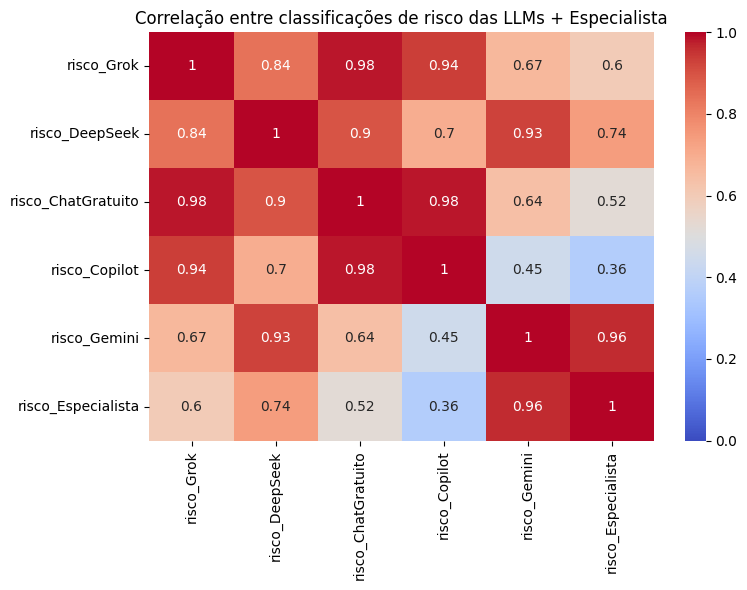

In [65]:
#HEATMAP

# 1. Carrega o arquivo consolidado
df = pd.read_csv('COMPILADO-classificacoes_multiplas.csv')

# 2. Converte os rótulos de risco para números
mapa_risco = {'Baixo': 0, 'Medio': 1, 'Alto': 2}

# Substitui applymap por apply + map (evita o FutureWarning)
df_num = df.drop(columns=['user']).apply(lambda col: col.map(mapa_risco))

# 3. Gera o heatmap de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlação entre classificações de risco das LLMs + Especialista')
plt.tight_layout()
plt.savefig("imagens/heatmap-llms", dpi=300)
plt.show()


In [ ]:


# 1. Carrega o dataset
df = pd.read_csv('COMPILADO-classificacoes_multiplas.csv')

# 2. Define ordem dos rótulos e cores
ordem_risco = ['Baixo', 'Medio', 'Alto']
cores = ['#fdb863', '#99d594', '#e66101']  # Laranja, Verde, Vermelho

# 3. Conta os rótulos por coluna (LLM) e garante presença de todos os rótulos
dados = df.drop(columns='user').apply(lambda col: col.value_counts()).T

# 4. Preenche com 0 se alguma coluna (risco) não existir
for r in ordem_risco:
    if r not in dados.columns:
        dados[r] = 0

# 5. Reorganiza as colunas na ordem desejada
dados = dados[ordem_risco]

# 6. Plota
plt.figure(figsize=(10, 6))
ax = dados.plot(kind='bar', stacked=True, color=cores, edgecolor='black', figsize=(10, 6))

plt.title('Distribuição de Riscos por IA', fontsize=16, fontweight='bold')
plt.xlabel('IA', fontsize=12)
plt.ylabel('Número de Classificações', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Risco', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_75071/2090707547.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_padronizado = df.drop(columns='user').applymap(lambda x: str(x).strip().capitalize())


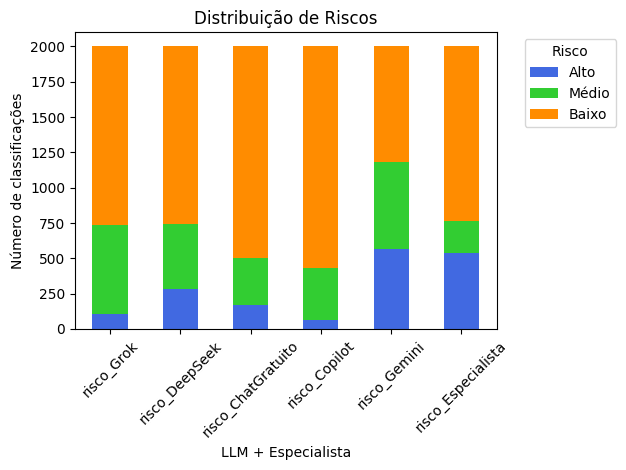

In [46]:
#GRAFICO BARRAS

# 1. Carrega o CSV
df = pd.read_csv('COMPILADO-classificacoes_multiplas.csv')

# 2. Padroniza os rótulos de risco
df_padronizado = df.drop(columns='user').applymap(lambda x: str(x).strip().capitalize())

# 3. Calcula a contagem de rótulos por LLM
df_freq = df_padronizado.apply(pd.Series.value_counts).T

# 4. Reordena as colunas na ordem desejada
ordem_riscos = ['Alto', 'Médio', 'Baixo']
df_freq = df_freq.reindex(columns=ordem_riscos, fill_value=0)

# 5. Define cores na mesma ordem
cores = ['royalblue', 'limegreen', 'darkorange']

# 6. Plota o gráfico
df_freq.plot(kind='bar', stacked=True, color=cores)

plt.title('Distribuição de Riscos')
plt.ylabel('Número de classificações')
plt.xlabel('LLM + Especialista')
plt.legend(title='Risco', labels=ordem_riscos, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imagens/grafico-barra-comparativo2.png", dpi=300)
plt.show()


In [ ]:
# KUSKAL WALLIS

from scipy.stats import kruskal

# Carrega os riscos de cada LLM
#grok = pd.read_csv('arquivos/V2-GROK-dataset_com_risco.csv')['risco']
#chatgpt = pd.read_csv('arquivos/V2-CHATGPT-dataset_com_risco.csv')['risco']
#deepseek = pd.read_csv('arquivos/V2-DEEPSEEK-dataset_com_risco.csv')['risco']
#copilot = pd.read_csv('arquivos/V2-COPILOT-dataset_com_risco.csv')['risco']
gemini = pd.read_csv('arquivos/V2-GEMINI-dataset_com_risco.csv')['risco']
especialista = pd.read_csv('arquivos/V2-ESPECIALISTA-dataset_com_risco.csv')['risco']
#grok, chatgpt, deepseek, copilot, 

# Executa o teste de Kruskal-Wallis
stat, p = kruskal(gemini, radha)

# Interpretação
print(f'Estatística H = {stat:.4f}')
print(f'p-valor = {p:.4f}')
if p < 0.05:
    print("✅ Diferença estatística significativa entre os grupos.")
else:
    print("ℹ️ Não há diferença estatisticamente significativa.")


Estatística H = 62.7342
p-valor = 0.0000
✅ Diferença estatística significativa entre os grupos.


In [41]:

from sklearn.metrics import cohen_kappa_score

# === 1. Carrega o CSV compilado ===
df = pd.read_csv("COMPILADO-classificacoes_multiplas.csv")

# === 2. Seleciona todas as colunas das LLMs (exceto risco_Especialista) ===
colunas_llm = [col for col in df.columns if col.startswith('risco_') and col != 'risco_Especialista']

# === 3. Calcula acurácia de concordância ===
print("Acurácia de Concordância e Kappa com risco_Especialista:\n")
for col in colunas_llm:
    total = len(df)
    acertos = (df[col] == df['risco_Especialista']).sum()
    acuracia = acertos / total
    kappa = cohen_kappa_score(df[col], df['risco_Especialista'])
    print(f"{col:<20} | Acurácia: {acuracia:.2%} | Kappa: {kappa:.3f}")



Acurácia de Concordância e Kappa com risco_Especialista:

risco_Grok           | Acurácia: 69.65% | Kappa: 0.457
risco_DeepSeek       | Acurácia: 76.45% | Kappa: 0.570
risco_ChatGratuito   | Acurácia: 74.60% | Kappa: 0.487
risco_Copilot        | Acurácia: 73.15% | Kappa: 0.446
risco_Gemini         | Acurácia: 62.15% | Kappa: 0.405


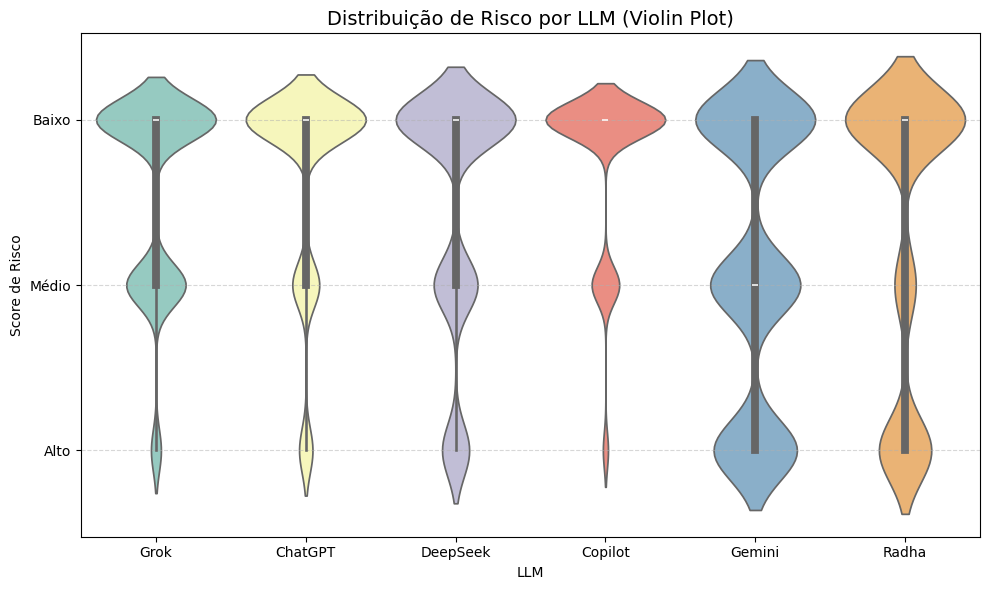

In [ ]:
#VIOLINO



# Lista de arquivos e nomes
arquivos = {
    'Grok': 'arquivos/V2-GROK-dataset_com_risco.csv',
    'ChatGPT': 'arquivos/V2-CHATGPT-dataset_com_risco.csv',
    'DeepSeek': 'arquivos/V2-DEEPSEEK-dataset_com_risco.csv',
    'Copilot': 'arquivos/V2-COPILOT-dataset_com_risco.csv',
    'Gemini': 'arquivos/V2-GEMINI-dataset_com_risco.csv',
    'Especialista' : 'arquivos/V2-ESPECIALISTA-dataset_com_risco.csv'
}

# Junta tudo em um único DataFrame
dados = []
for nome, arquivo in arquivos.items():
    df = pd.read_csv(arquivo)
    df_filtrado = df[['risco']].copy()
    df_filtrado['LLM'] = nome
    dados.append(df_filtrado)

df_riscos = pd.concat(dados, ignore_index=True)

# === Violin Plot corrigido ===
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_riscos,
    x='LLM',
    y='risco',
    hue='LLM',             # adiciona agrupamento por cor
    palette='Set3',
    inner='box',
    legend=False           # evita legenda repetida
)
plt.title('Distribuição de Risco por LLM (Violin Plot)', fontsize=14)
plt.ylabel('Score de Risco')
plt.xlabel('LLM')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [104]:
print("Colunas disponíveis em df_risco:", df_risco.columns.tolist())


Colunas disponíveis em df_risco: ['Baixo', 'Médio', 'Alto']
